In [1]:
import ast
from collections import Counter
from gensim import utils, matutils 
from gensim.corpora.dictionary import Dictionary
from gensim.utils import deprecated
import itertools
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as LA
from numpy.random import binomial
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from numpy.linalg import norm
import math, copy, time
import warnings 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import load_model

import os, sys, re, io, nltk, torch
import pandas as pd

from scipy import stats
from scipy.stats import bernoulli
from scipy.spatial import distance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score, precision_score

from six import string_types, integer_types
from six.moves import zip, range
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm, trange
import time
import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable


'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        #print ("aux original", aux)
        #print ("aux restado...",aux-np.ones(aux.shape))
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

"""class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)"""
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #print ("mask para attn...", mask)
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        #x_text=x.data[:,0][:,None,:]
        #x_machines=x.data[:,1:]
        #x_return = x_machines* x_text
        return self.dropout(x)   #(x_return)
    
"""class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)"""

    
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #print ("Rate de Noam_opt", self._rate, self._step)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        #print ("nuevo Y en simplelosscompute", y_new, "antes era", y)
        # ahora
        #y_new=(y.float()).int()
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])


def data_gen(batch_size,mode):  
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=x_train.shape[0]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=x_val.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0] for x in x_list]   
        np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['Tw_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=x_test.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0]+x_val.shape[0] for x in x_list]
        total=x_train.shape[0]+x_val.shape[0]
        objs=test['Tw_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]]
            #for m in range(n_machines): 
            #    temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
            temp.append(temp2)
        new_x_data.append(temp)  

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)            
                        
            
            
def make_model_concat(target, N=2, d_model=768, d_ff=128, h=4, dropout=0.35, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last
    
stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)      
    s= re.sub(r'#\w+ ?', "hashtag", s) 
    s= re.sub(r'@\w+ ?', "user", s)
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}

dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'
#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)


val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

MAX_LEN=50
#########################################################

etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


Pesos de clases: [1. 1. 1. 1.]


(1021, 50, 768)

Entrenando Run # 1
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.1701, dtype=torch.float64) 	F-macro_val: tensor(0.1458, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.2500, dtype=torch.float64) 	F-macro_val: tensor(0.1944, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.3472, dtype=torch.float64) 	F-macro_val: tensor(0.2777, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.3993, dtype=torch.float64) 	F-macro_val: tensor(0.3031, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.4097, dtype=torch.float64) 	F-macro_val: tensor(0.2854, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.4583, dtype=torch.float64) 	F-macro_val: tensor(0.2970, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.4132, dtype=torch.float64) 	F-macro_val: tensor(0.3110, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.4479, dtype=torch.float64) 	F-macro_val: tensor(0.3152, dtype=torch.float64)
Epoch 8 	acc_val: tensor(0.3750, dtype=torch.float64) 	F-macro_val: tensor(0.2969, dtype=t

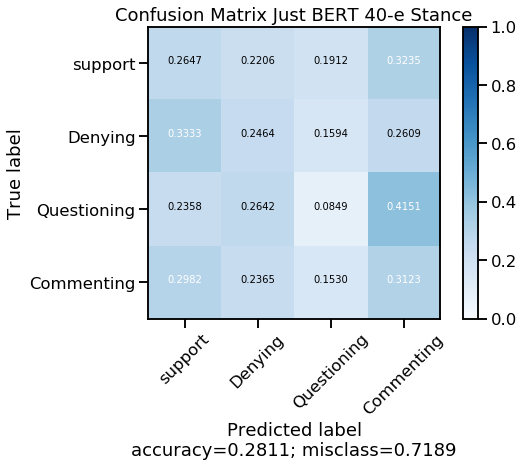

Test_ acc: 0.2810969637610186
Test_ f1 none: [0.09836066 0.1086262  0.06976744 0.439819  ]
Test_ f1 macro: 0.17914332505153097
Entrenando Run # 2
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.2569, dtype=torch.float64) 	F-macro_val: tensor(0.1692, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.2361, dtype=torch.float64) 	F-macro_val: tensor(0.2084, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.4271, dtype=torch.float64) 	F-macro_val: tensor(0.3202, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.4167, dtype=torch.float64) 	F-macro_val: tensor(0.3082, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.3646, dtype=torch.float64) 	F-macro_val: tensor(0.2961, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.4236, dtype=torch.float64) 	F-macro_val: tensor(0.3137, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.4097, dtype=torch.float64) 	F-macro_val: tensor(0.2944, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.4028, dtype=torch.float64) 	F-macro_val:

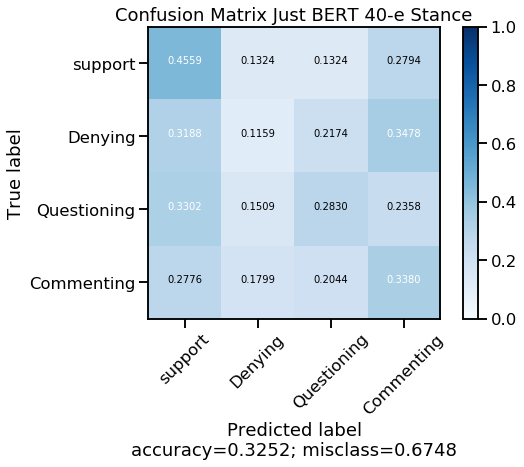

Test_ acc: 0.32517140058765914
Test_ f1 none: [0.16666667 0.0661157  0.18808777 0.47430117]
Test_ f1 macro: 0.22379282891697705
Entrenando Run # 3
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.1806, dtype=torch.float64) 	F-macro_val: tensor(0.1421, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.1910, dtype=torch.float64) 	F-macro_val: tensor(0.1699, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.3264, dtype=torch.float64) 	F-macro_val: tensor(0.2466, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.4931, dtype=torch.float64) 	F-macro_val: tensor(0.3597, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.3507, dtype=torch.float64) 	F-macro_val: tensor(0.2683, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.4201, dtype=torch.float64) 	F-macro_val: tensor(0.3127, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.4410, dtype=torch.float64) 	F-macro_val: tensor(0.3415, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.4028, dtype=torch.float64) 	F-macro_val

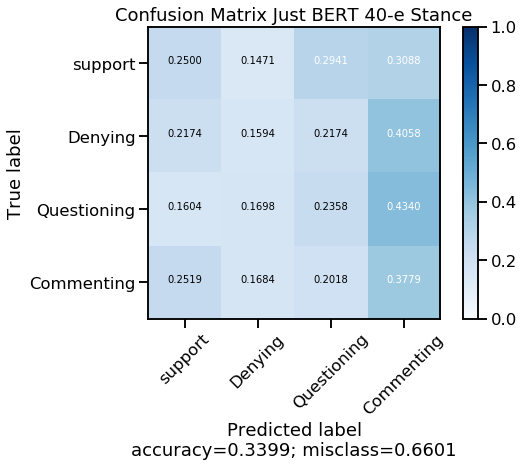

Test_ acc: 0.33986287952987265
Test_ f1 none: [0.1086262  0.09205021 0.15479876 0.50385604]
Test_ f1 macro: 0.21483280250727513
Entrenando Run # 4
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.1944, dtype=torch.float64) 	F-macro_val: tensor(0.1598, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.2292, dtype=torch.float64) 	F-macro_val: tensor(0.2104, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.2639, dtype=torch.float64) 	F-macro_val: tensor(0.2233, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.3611, dtype=torch.float64) 	F-macro_val: tensor(0.2742, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.3819, dtype=torch.float64) 	F-macro_val: tensor(0.3285, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.4722, dtype=torch.float64) 	F-macro_val: tensor(0.3572, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.3819, dtype=torch.float64) 	F-macro_val: tensor(0.2913, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.3681, dtype=torch.float64) 	F-macro_val

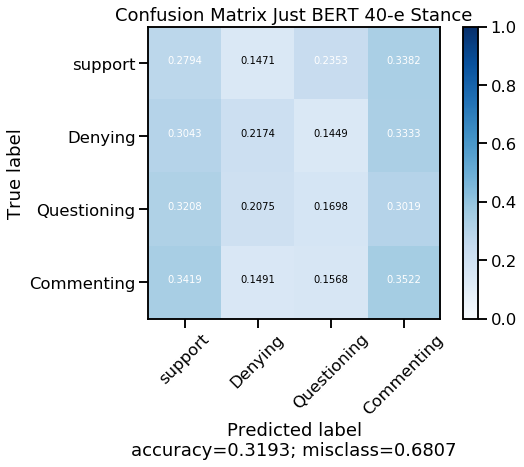

Test_ acc: 0.31929480901077373
Test_ f1 none: [0.09313725 0.12931034 0.13235294 0.48495575]
Test_ f1 macro: 0.20993907327960176
Entrenando Run # 5
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.1979, dtype=torch.float64) 	F-macro_val: tensor(0.1708, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.2882, dtype=torch.float64) 	F-macro_val: tensor(0.2250, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.3194, dtype=torch.float64) 	F-macro_val: tensor(0.2437, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.3194, dtype=torch.float64) 	F-macro_val: tensor(0.2413, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.2986, dtype=torch.float64) 	F-macro_val: tensor(0.2318, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.3333, dtype=torch.float64) 	F-macro_val: tensor(0.2534, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.3750, dtype=torch.float64) 	F-macro_val: tensor(0.2945, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.3438, dtype=torch.float64) 	F-macro_val

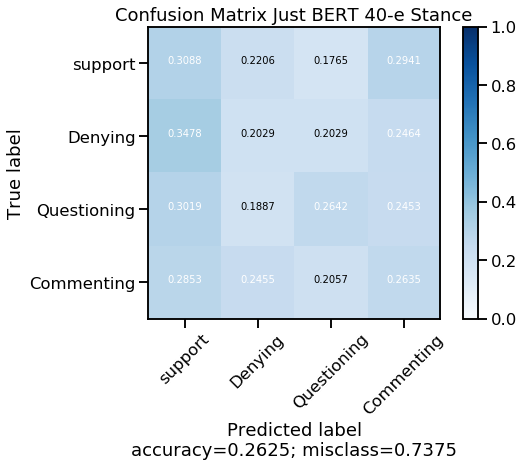

Test_ acc: 0.2624877571008815
Test_ f1 none: [0.11444142 0.09061489 0.175      0.39196941]
Test_ f1 macro: 0.19300642772272472


In [3]:
prob=0.15

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
    model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
    idx_2_token = tokenizer_loaded.ids_to_tokens
    archivo = open(dir_path+'vocab.txt','r')
    Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
    M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    transformer = Normalizer().fit(M_BERT_space) 
    M_BERT_space=transformer.transform(M_BERT_space)
    macro_augmented= np.load('../Data_augmented/Stance_agregado/Aumento_'+str(trans)+'-run_'+str(prob)+'_balanced_w4_app1_Top1.npy', allow_pickle=True)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    bs=32
    
    
    espacio=[np.ones(768)]
    Ks=np.load("../../../BERTransformer/Orthogonals_768.npy")
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(labels_train)):
        folder='Original'
        ide=ids_train[i]
        clase=dict_cl[labels_train[i]]
        if ide<5000000:
            folder=clase #directorio a recuperar vector
            vector=np.load("../../BERTasService/"+str(prob)+"/"+str(trans)+"/"+folder+"/"+str(ide)+".npy")
        else:
            vector=np.load("../../BERTasService/"+folder+"/"+str(ide)+".npy")

        norm=np.linalg.norm(vector)
        vector= vector / norm
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(vector)

    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])

    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        vector=np.load("../../BERTasService/Original/"+str(i)+".npy")
        norm=np.linalg.norm(vector)
        vector= vector / norm
        index_embeddings.append(num+5+macro_augmented.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(vector)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    del tokenizer_loaded 
    del model_loaded 
    del idx_2_token 
    del M_BERT_space
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    print (pesos)
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=768, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 500, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    for epoch in range(40):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        print ("Epoch",epoch, "\tacc_val:",acc_val, "\tF-macro_val:",fma_val)
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
        
    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

    plot_confusion_matrix(glo_cm,["support","Denying","Questioning","Commenting"],"Confusion Matrix Just BERT 40-e Stance")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 



## Comportamiento Global promedio

In [4]:
np.mean(np.asarray(global_accs))

0.3055827619980411

In [5]:
np.mean(np.asarray(global_fmacros))

0.20414289149562195

In [6]:
global_fnones

[array([0.09836066, 0.1086262 , 0.06976744, 0.439819  ]),
 array([0.16666667, 0.0661157 , 0.18808777, 0.47430117]),
 array([0.1086262 , 0.09205021, 0.15479876, 0.50385604]),
 array([0.09313725, 0.12931034, 0.13235294, 0.48495575]),
 array([0.11444142, 0.09061489, 0.175     , 0.39196941])]

In [7]:
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])
print (sup,den,que,com)

0.11624643845662648 0.09734346826528092 0.14400138378830274 0.45898027547227754


In [8]:
m_temp=np.zeros((4,4))
for m in global_cms:
    #print ("matrix",m, np.asarray(m, dtype='int').shape)
    m_temp+=np.asarray(m)
    #print ("\nLa suma dio:", m_temp)
m_temp

array([[ 106.,   59.,   70.,  105.],
       [ 105.,   65.,   65.,  110.],
       [ 143.,  104.,  110.,  173.],
       [1132.,  762.,  717., 1279.]])

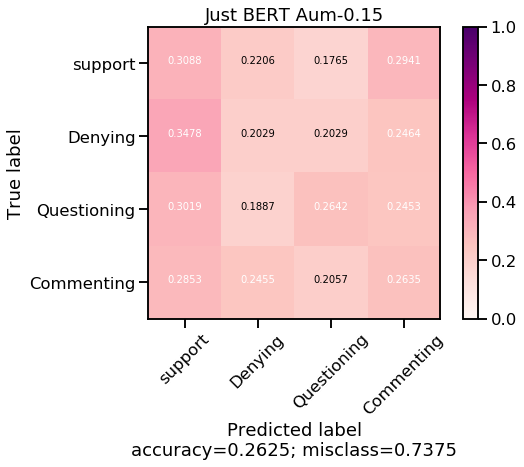

In [9]:
plot_confusion_matrix(glo_cm,["support","Denying","Questioning","Commenting"],"Just BERT Aum-0.15", cmap='RdPu')
